In [28]:
import cv2
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
# import Augmentor

In [2]:
# load monkbrill jpg data
data = dict()
data['label'] = []
data['filename'] = []
data['data'] = []   

data_path = "monkbrill-jpg/"
for subdir in os.listdir(data_path):
    current_path = os.path.join(data_path, subdir)

    for file in os.listdir(current_path):
        im = cv2.imread(os.path.join(current_path, file), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, (38, 48)) # (width, height)
        data['label'].append(subdir)
        data['filename'].append(file)
        data['data'].append(im)

In [14]:
# one-hot encode class labels
encoder = LabelBinarizer()
onehot_labels = encoder.fit_transform(data['label'])

In [70]:
# split in training and validation data and normalize
X_train, X_val, y_train, y_val = train_test_split(data['data'], onehot_labels, test_size=0.2, random_state=0, shuffle=True)
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train) 
X_val = np.array(X_val) / 255.0
y_val = np.array(y_val)

In [71]:
# Build LeNet model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(48, 38, 1)))
model.add(MaxPool2D(strides=2))
model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
model.add(MaxPool2D(strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 38, 32)        832       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 19, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 20, 15, 48)        38448     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 10, 7, 48)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 10, 7, 48)         0         
                                                                 
 flatten_8 (Flatten)         (None, 3360)             

In [24]:
# Compile and train model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_filepath = 'models/LeNet_model.h5'
callback = ModelCheckpoint(filepath=model_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
history = model.fit(X_train, y_train, epochs=10, validation_data = (X_val, y_val), callbacks = [callback], verbose=1)

Epoch 1/10
139/139 [==============================] - 7s 45ms/step - loss: 1.1933 - accuracy: 0.6780 - val_loss: 0.5011 - val_accuracy: 0.8574
Epoch 2/10
139/139 [==============================] - 6s 45ms/step - loss: 0.4661 - accuracy: 0.8625 - val_loss: 0.2891 - val_accuracy: 0.9224
Epoch 3/10
139/139 [==============================] - 6s 44ms/step - loss: 0.2955 - accuracy: 0.9117 - val_loss: 0.2440 - val_accuracy: 0.9359
Epoch 4/10
139/139 [==============================] - 6s 44ms/step - loss: 0.2095 - accuracy: 0.9341 - val_loss: 0.2335 - val_accuracy: 0.9314
Epoch 5/10
139/139 [==============================] - 6s 44ms/step - loss: 0.1650 - accuracy: 0.9433 - val_loss: 0.2275 - val_accuracy: 0.9395
Epoch 6/10
139/139 [==============================] - 6s 44ms/step - loss: 0.1229 - accuracy: 0.9580 - val_loss: 0.2442 - val_accuracy: 0.9449
Epoch 7/10
139/139 [==============================] - 6s 45ms/step - loss: 0.0887 - accuracy: 0.9686 - val_loss: 0.2295 - val_accuracy: 0.9504

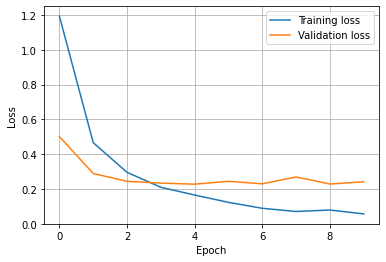

In [25]:
# Plot the loss
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()


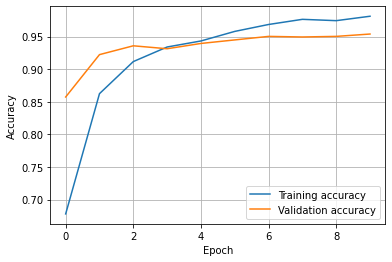

In [26]:
# Plot the accurcy
plt.plot(history.history['accuracy'], label = 'Training accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()